# Naive approach to quantum machine learning for cnn based on https://arxiv.org/abs/1904.04767

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [61]:
epochs = 50
batch_size = 32
learning_rate = 1e-3
num_train_images = 200 #being the quantum data augmentation slow is better not to use a lot of images and quantum filters
num_quantum_filters = 3
#the training will be done with the same amount of images in all of the 3 cases
num_train_imgs_no_augmentation = num_train_images + num_train_images*num_quantum_filters

"""
how many qbits to use depends on the embedding strategy: 
basis and angle embdedding require a number o qbits equals to the size of the filters (num_quantum_filters**2)
while with amplitude embdedding the number depends on the number of features being a power of 2 or not
"""
quantum_device = qml.device("default.qubit", wires=9)

In [66]:
"""
QUANTUM PART FUNCTIONS
"""

def round_to_power2(x):
    """
    Returns the rounded (by excess) a number to the closest power of 2 
    and the relative power
    e.g. round_to_power2(6) = (8, 3), round_to_power2(9) = (16, 4) 

    used for the number of qbits required in amplitude embeding
    which are log2(features)
    """
    y = np.ceil(np.log2(x))
    return int(2**(y)), int(y)


def float_to_bool(tensor, threshold):
    """
    turns an array of any shape of floats in [0,1] in an array 
    with boolean values in {0,1} given a certain threshold   

    used for basis embedding which requires boolean features
    """
    #where the element is below threshold returns 0, else 1
    tensor = np.where(tensor<=threshold, 0., 1.)

    return tensor
    
    

@qml.qnode(quantum_device)
def quantum_preprocess_layer(
    input, 
    embedding, 
    threshold_basis_embedding=0.65,
    epsilon_ampliture_embedding=0.00000001,
    rotation_angle_embedding='X'):
    """
    threshold_basis_embdedding is an arbitray float to decides the 
    brightness a pixel has to have in order to be approximated to 1.
    due to the boolean features basis embdedding requires

    epsilon_aplitude_embedding is a small arbitray value used to have a 
    non zero amplitude when one has to encode a completely black image
    """

    features = np.ravel(input)
    
    if embedding == 'amplitude':    
        _, num_qbits = round_to_power2(len(features))
        features = np.where(features==0., features+epsilon_ampliture_embedding, features)
        qml.AmplitudeEmbedding(features=features, wires=range(num_qbits), pad_with=0., normalize=True)

    elif embedding == 'basis':
        num_qbits = len(features)
        features = float_to_bool(features, threshold=threshold_basis_embedding)
        qml.BasisEmbedding(features=features, wires=range(num_qbits))

    elif embedding == 'angle':
        num_qbits = len(features)
        features = features*np.pi
        qml.AngleEmbedding(features=features, wires=range(num_qbits), rotation=rotation_angle_embedding)


    else:
        raise Exception("Valid embeddings: basis, angle, amplitude")

    """
    the random circuit consist in a number of gates randomly chosen from {0, num_qbits}
    all of them with the same angle and some CNOTs
    """

    num_single_gates = random.randint(0,num_qbits)
    theta = random.uniform(0, 2*np.pi)
    weights = np.array([[theta for _ in range(num_single_gates)]])
    qml.RandomLayers(weights=weights, wires=range(num_qbits))
    
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qbits)]
   
def quantum_conv(
    image,
    quantum_filters,
    embedding,
    dim_quantum_kernel=3,
    padding='same',
    stride=1,
    activation='relu'):
    """
    returns the image processed by the quantum circuit 
    as would do a classical convolutional layer as 
    a tensor with shape (img_size_out, img_size_out, num_qunatum_filters)
    with img_size_out that dependds on the padding and seize of quantum kernel
    """

    if padding == 'same':
        output_tensor = np.empty([image.shape[0], image.shape[1], quantum_filters])
        padded_image = np.pad(image, pad_width=[(1,1), (1,1), (0,0)], constant_values=(0,))

    for i in range(0, image.shape[0], stride):
        for j in range(0, image.shape[1], stride):
            
            input_tensor = padded_image[i:i+dim_quantum_kernel, j:j+dim_quantum_kernel, :]
            
            for qfilter in range(quantum_filters):

                outputs = quantum_preprocess_layer(
                    input_tensor,
                    embedding=embedding)

                output = np.mean(outputs)
                
                if activation == 'relu':
                    output = keras.activations.relu(output).numpy()
                
                if activation == 'sigmoid':
                    output = keras.activations.sigmoid(output).numpy()

                if activation == 'tanh':
                    output = keras.activations.tanh(output).numpy()

                output_tensor[i,j,qfilter] = output
    
    return output_tensor


def quantum_augmentation(dataset, labels, num_quantum_filters, embedding):
    
    augmented_dataset = dataset
    augmented_labels = labels

    for idx in range(len(dataset)):
        
        aug_imgs = quantum_conv(dataset[idx,:,:,:], num_quantum_filters, embedding)
        
        for i in range(aug_imgs.shape[-1]):
            aug_img = np.expand_dims(aug_imgs[:,:,i], axis=(0,3))
            augmented_dataset = np.append(augmented_dataset, aug_img, axis=0)
            augmented_labels = np.append(augmented_labels, [labels[idx]], axis=0)

    return augmented_dataset, augmented_labels

In [5]:
"""
CLASSICAL MODEL FUNCTIONS
"""

def conv_block(
    input,
    num_filters,
    kernel_size=3,
    pool_size=2,
    padding='same',
    dropout=False,
    drop_rate=0.5,
    spatial_drop_rate = 0.3,
    activation='relu',):

    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=activation,
    )(input)

    x = layers.MaxPooling2D(pool_size=pool_size)(x)

    if dropout == 'classic':
        x = layers.Dropout(drop_rate)(x)
    
    if dropout == 'spatial':
        x = layers.SpatialDropout2D(spatial_drop_rate)(x)
    
    return x


def fc_block(
    input,
    nodes,
    num_layers=1,
    dropout = True,
    drop_rate = 0.5,
    activation = 'relu',
    l2_regularization = True,
    l2_penalty = 1e-3,
):

    x = layers.Flatten()(input)

    for layer in range(num_layers):

        if l2_regularization:
            x = layers.Dense(nodes,
            activation=activation,
            activity_regularizer=keras.regularizers.L2(l2_penalty))(x)

        else:
            x = layers.Dense(nodes,
            activation=activation,)(x)
        
        if dropout:
            x = layers.Dropout(drop_rate)(x)

    return x


def build_model(img_size, num_classes):

    input = keras.Input(shape=(img_size,img_size,1))

    x = conv_block(input, num_filters=16)
    x = conv_block(x, num_filters=32)
    x = fc_block(x, nodes=64, drop_rate=0.6)

    output = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs=input, outputs=output)

In [6]:
"""
PLOTTING FUNCTIONS
"""

def plot_loss_metric(loss, val_loss, metric, val_metric, metric_name='accuracy'):

    epochs_range = range(len(loss))

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    if metric_name == 'accuracy':
        plt.plot(epochs_range, metric, label='Training Accuracy')
        plt.plot(epochs_range, val_metric, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
    elif metric_name == 'recall':
        plt.plot(epochs_range, metric, label='Training Recall')
        plt.plot(epochs_range, val_metric, label='Validation Recall')
        plt.title('Training and Validation Recall')
    elif metric_name == 'precision':
        plt.plot(epochs_range, metric, label='Training Precision')
        plt.plot(epochs_range, val_metric, label='Validation Precision')
        plt.title('Training and Validation Precision')
    plt.legend(loc='lower right')
    

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [54]:
def prep_dataset(dataset):

    dataset = dataset/255.
    dataset = np.expand_dims(dataset, axis=3)

    return dataset


def add_gaussian_noise(dataset, labels, multiplier=num_quantum_filters, mean=0.0, stddev=0.2):

    new_dataset = dataset
    new_labels = labels

    for i in range(len(dataset)):
        for _ in range(multiplier):
            aug_image = dataset[i]
            aug_image += tf.random.normal(shape=tf.shape(aug_image), mean=mean, stddev=stddev, dtype=tf.float32)
            aug_image = np.clip(aug_image, 0., 1.)
            aug_image = np.expand_dims(aug_image, axis=0)
            new_dataset = np.append(new_dataset, aug_image, axis=0)
            new_labels = np.append(new_labels, [labels[i]], axis=0)

    return new_dataset, new_labels

In [8]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images[:num_train_images]
train_labels = train_labels[:num_train_images]
test_images = test_images[:num_train_images]
test_labels = test_labels[:num_train_images]

In [431]:
out = quantum_conv(train_images[0], quantum_filters=5, embedding='angle')

The images after quantum post process present some kind of noise and inverted pixels

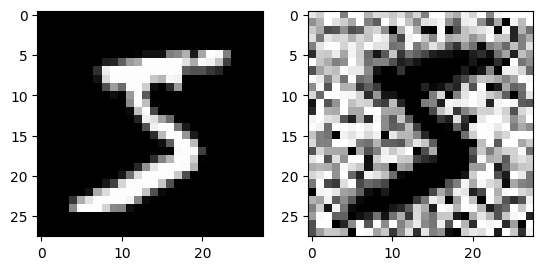

In [434]:
#plotting the effect of quantum preprocessing
plt.subplot(1,2,1)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out[:,:,0], cmap='gray')

In [86]:
new_dataset, new_labels = quantum_augmentation(train_images, train_labels, num_quantum_filters, embedding='angle')

In [88]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.25, random_state=25)

In [ ]:
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

## Training on the base dataset

In [62]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images[:num_train_imgs_no_augmentation]
train_labels = train_labels[:num_train_imgs_no_augmentation]
test_images = test_images[:num_train_imgs_no_augmentation]
test_labels = test_labels[:num_train_imgs_no_augmentation]
train_images = prep_dataset(train_images)
test_images = prep_dataset(test_images)
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.25, random_state=25)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model = build_model(28, 10)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    epochs=epochs,
    shuffle=False,
)

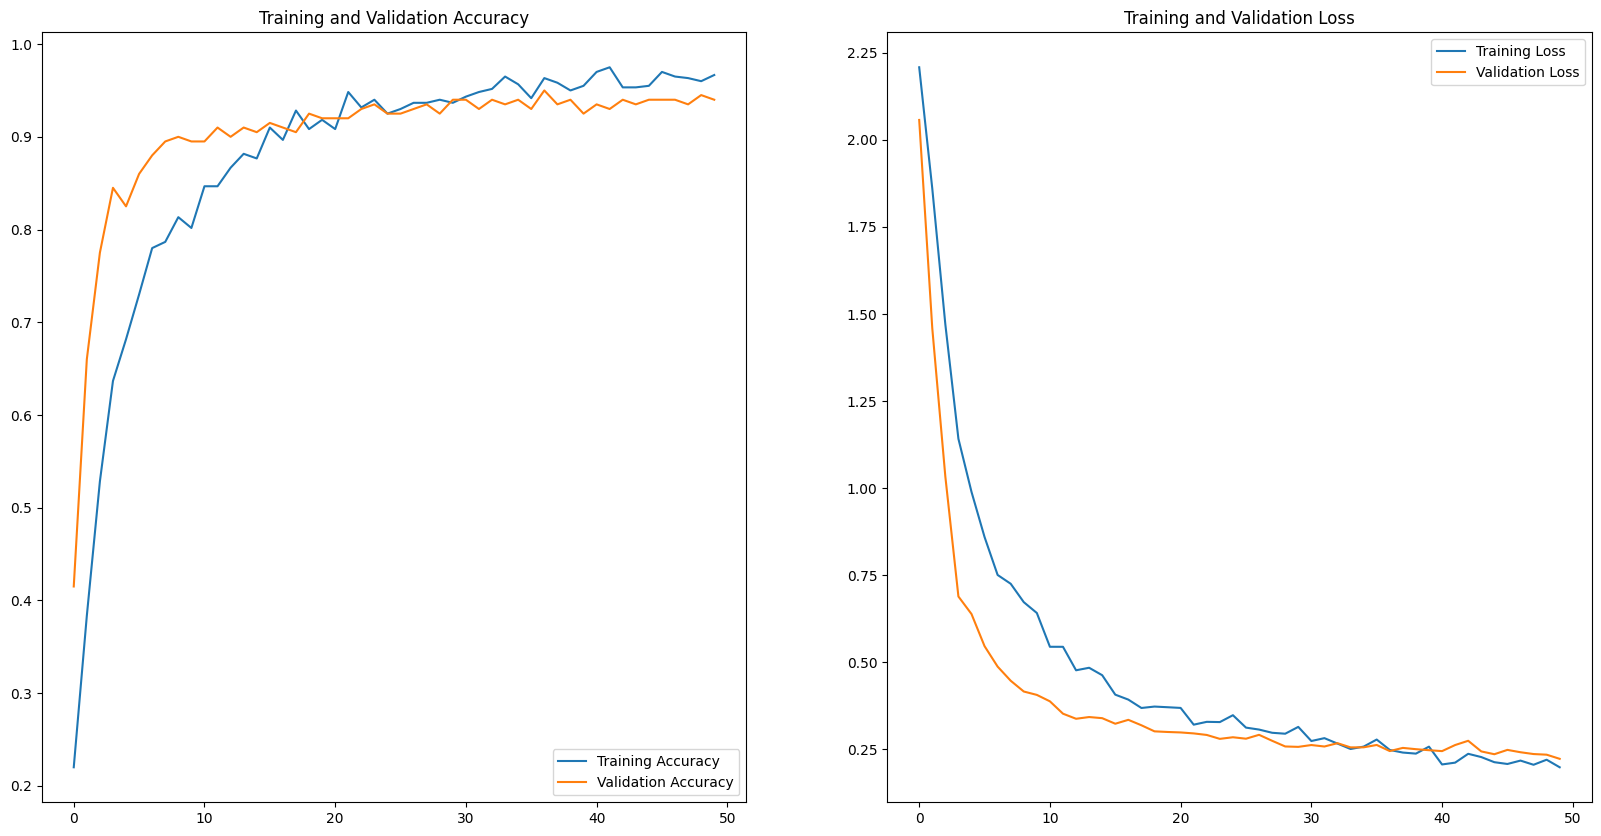

In [64]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plot_loss_metric(loss, val_loss, acc, val_acc)

## Training on the quantum augmented dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images[:num_train_images]
train_labels = train_labels[:num_train_images]
test_images = test_images[:num_train_images]
test_labels = test_labels[:num_train_images]
train_images = prep_dataset(train_images)
test_images = prep_dataset(test_images)
new_dataset, new_labels = quantum_augmentation(train_images, train_labels, num_quantum_filters, embedding='angle')
x_train_q, x_val_q, y_train_q, y_val_q = train_test_split(new_dataset, new_labels, test_size=0.25, random_state=25)
y_train_q = keras.utils.to_categorical(y_train_q)
y_val_q = keras.utils.to_categorical(y_val_q)

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model = build_model(28, 10)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

history_q = model.fit(
    x = x_train_q,
    y = y_train_q,
    batch_size=batch_size,
    validation_data=(x_val_q, y_val_q),
    epochs=epochs,
    shuffle=True,
)

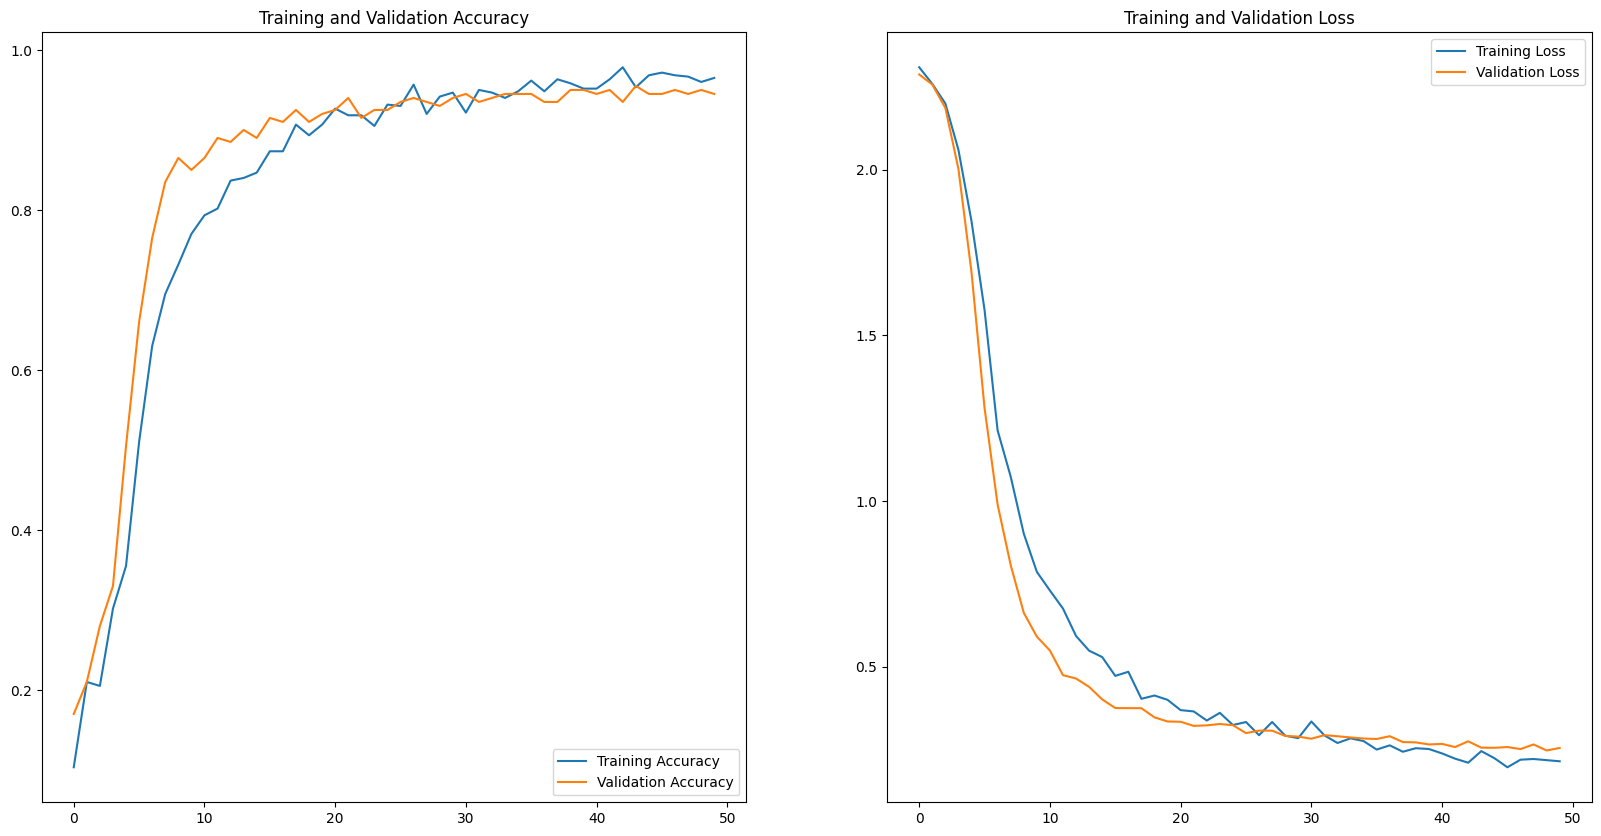

In [102]:
loss = history_q.history['loss']
val_loss = history_q.history['val_loss']
acc = history_q.history['accuracy']
val_acc = history_q.history['val_accuracy']

plot_loss_metric(loss, val_loss, acc, val_acc)

## Training with gaussian noise as data augmentation

In [55]:
gaussian_dataset, gaussian_labels = add_gaussian_noise(train_images, train_labels)

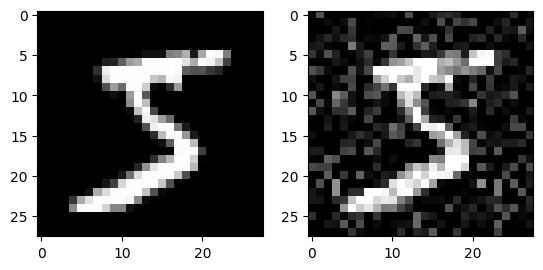

In [56]:
#plotting the effect of gaussian noise 
plt.subplot(1,2,1)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gaussian_dataset[200,:,:,:], cmap='gray')

In [57]:
x_train_g, x_val_g, y_train_g, y_val_g = train_test_split(gaussian_dataset, gaussian_labels, test_size = 0.25, random_state=25)
y_train_g = keras.utils.to_categorical(y_train_g)
y_val_g = keras.utils.to_categorical(y_val_g)

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model = build_model(28, 10)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

history_g = model.fit(
    x = x_train_g,
    y = y_train_g,
    batch_size=batch_size,
    validation_data=(x_val_g, y_val_g),
    epochs=epochs,
    shuffle=True,
)

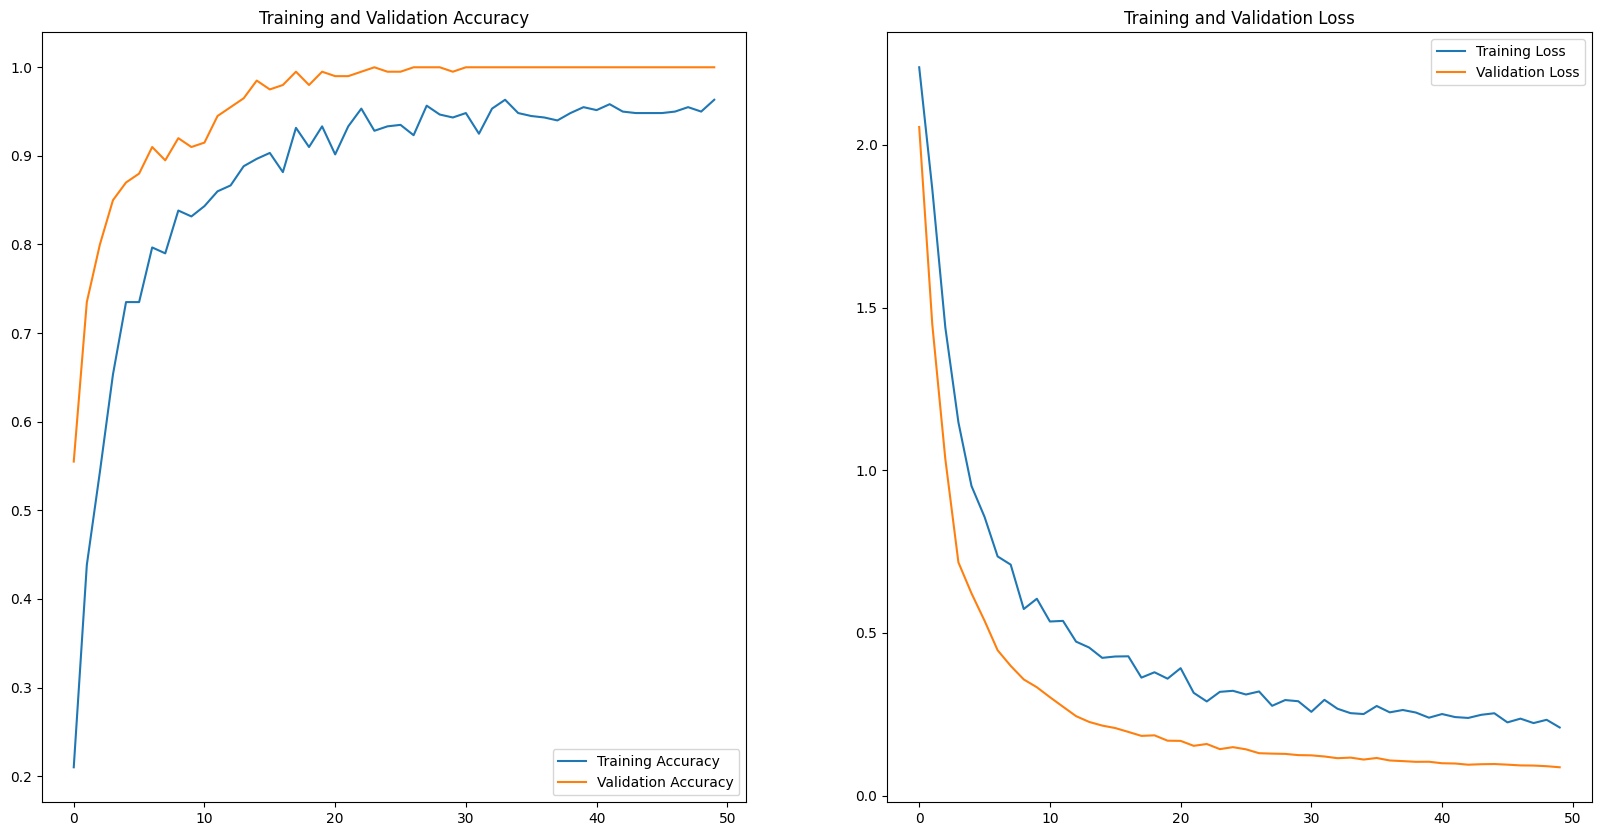

In [59]:
loss = history_g.history['loss']
val_loss = history_g.history['val_loss']
acc = history_g.history['accuracy']
val_acc = history_g.history['val_accuracy']

plot_loss_metric(loss, val_loss, acc, val_acc)

Using a quantum circuit just for data augmentation, without training it, doesn't seem an interersting usage as the quantum augmented dataset performed
in a comparable way to the plain dataset

As one can see the quantum augmentation equal to adding noise to the image, which is the same (or even worse in this particular case) 
as using some preprocessing already implemented in every deeplearning libray 